# Part 2: Supervised Learning Model
Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from cleaning_functions import clean_data
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc,accuracy_score,confusion_matrix

# Classification Models

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# load in the data of training set
#There will appear a warning when reading the sets but it's fine, it just needs cleaning, we will do that later on
train_df = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


/tmp/ipykernel_619/350423766.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [3]:
#copying and viewing the train set
train_set = train_df.copy()
train_set.head()


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [4]:
train_set.shape

(42962, 367)

# Exploratory Data Analysis:
To gain information about our dataset through visualisations:

RESPONSE
0    42430
1      532
Name: count, dtype: int64

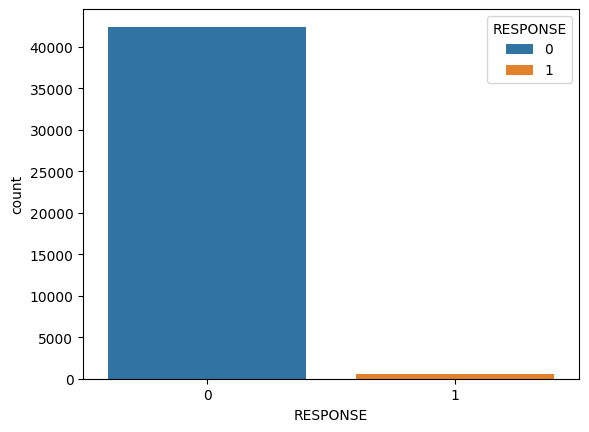

In [5]:
#let's view the response column that have 0s and 1s, the column we will be focusing on:

response_plot = sb.countplot(x='RESPONSE', data=train_set, hue="RESPONSE")

#see the count of 0s and ones:

train_set['RESPONSE'].value_counts()


In [6]:
#The missing values:
training_missing_values = (train_set.isnull().sum()/train_set.shape[0]) * 100

(42962, 367)

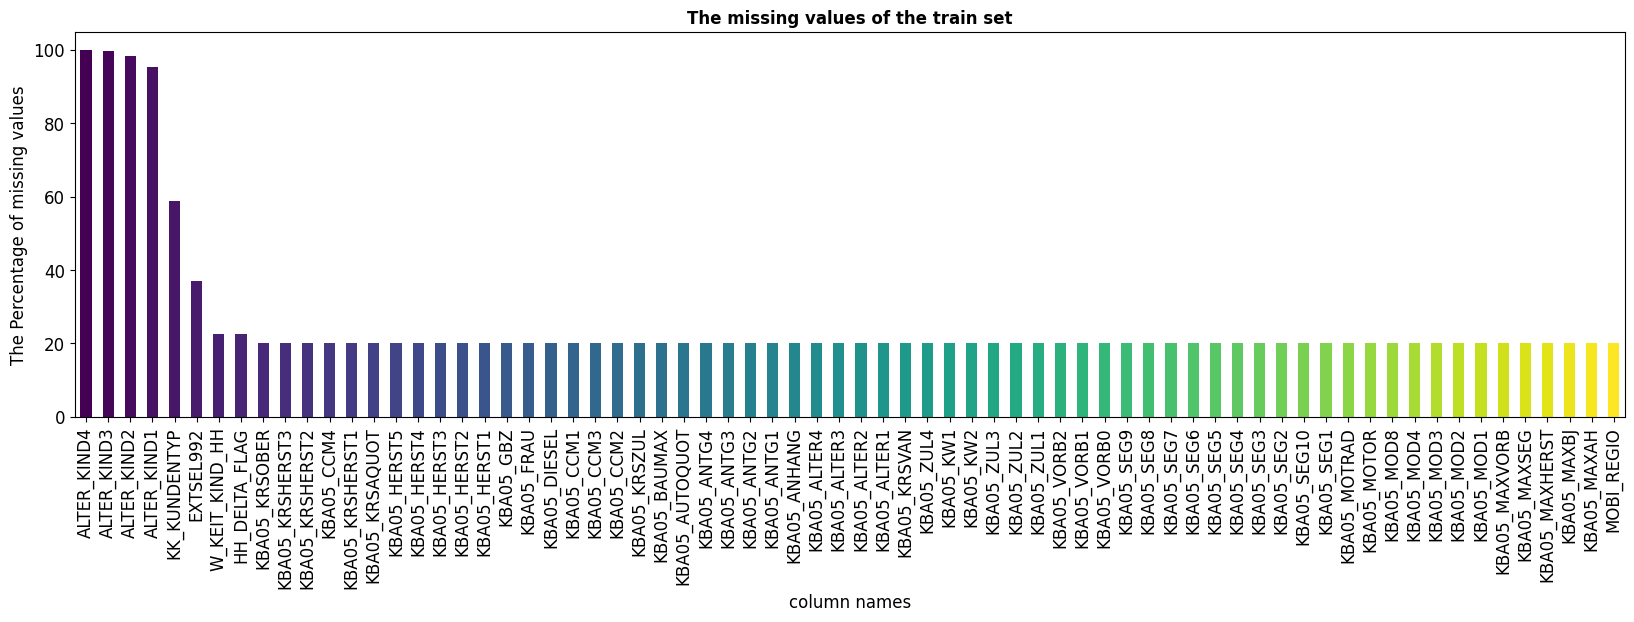

In [7]:
# we can visualize it 
num_bars = 70
colors = plt.cm.viridis(np.linspace(0, 1, num_bars)) 

plt.title('The missing values of the train set', fontsize=12, fontweight="bold")
plt.xlabel('column names', fontsize=12)
plt.ylabel('The Percentage of missing values', fontsize=12)
training_missing_values.sort_values(ascending=False)[:num_bars].plot(kind='bar', figsize=(20,5), fontsize=12, color=colors)
train_set.shape

# Cleaning data and Testing with a Benchmark Model:

Our Benchmark model is Logistic Regression model, so 1st we will clean, 2) extract x and y, 3) train, test and split the data and 4) test the data with model in order to see its accuracy without scaling or improving the models parameters 

In [5]:
#clean data is a function that cleans and prepares it for testing
cleaned_train=clean_data(train_set)

A) The First Step: Dropping the unnecessary columns. 

The columns that were successfully dropped are: 
 1) Columns that have more than 20% of missing values. 
 2) Columns that have no description in the files. 
 3) Columns that are noisy because it contains many different items. 
 4) The ID Column.
Creating a copy of the dataframe after dropping columns. 

B) The Second Step: Replace O with 0 and W with 1 in OST_WEST_KZ attribute. 

C) The Third Step: Rename the WOHNLAGE column to TYPE_RESIDENTIAL_AREA. 

D) The Fourth Step: apply feature engineering on TYPE_RESIDENTIAL_AREA values. It is better to reduce the noise. 

E) The Fifth Step: Dropping the original column: WOHNLAGE. 

Feature extracting CAMEO_DEUG_2015. 

F) The Sixth Step: Checking the values of the object type column: CAMEO_DEUG_2015 and transforming to a numeric type. 

G) The Seventh Step: removing columns with start with KBA05. 
 
H) The Eighth Step: Imputing Nan values using the most frequent number.


In [6]:
#seeing the shape of the original dataset and the same dataset after cleaning
print(cleaned_train.shape, train_df.shape)

(42962, 249) (42962, 367)


In [10]:
#expands the columns so we can see them all
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [11]:
cleaned_train.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_TYP_1,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_MOBILE,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_GROB,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,STRUKTURTYP,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,RESPONSE,ALTERSKATEGORIE_GROB,TYPE_RESIDENTIAL_AREA
0,1763.0,1.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,5.0,2.0,2.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.0,1.0,5.0,2.0,5.0,3.0,1.0,1.0,5.0,6.0,2.0,3.0,3.0,12.0,8.0,2.0,0

In [7]:
#specifiying X and y for the model:

X = cleaned_train.drop(['RESPONSE'], axis=1)
y = cleaned_train['RESPONSE']

#split the data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.shape, X_test.shape, y_train.shape, y_test.shape

((42962, 248), (8593, 248), (34369,), (8593,))

# Machine Learning Algorithms:

So since this is a binary classification problem, we will So using different types of classifiers such as, Gradient Boosting, KNeighbors and Adaboost algorithms to predict whether a person became a customer of the company's campaign or not. But before we start training the data, we will establish benchmark model. A simple algorithm like the Logistic Regression without testing the effective parameters.

# What Metrics did we choose? :-
There are many evaluation metrics such as, accuracy, confusion matrix and for this particular problem AUC for the ROC curve, it tells us about the ability to detect actual customers  and the actual non-customers.

The AUC(Area Under the Curve)-ROC curve(receiver operating characteristic) is a graphical plot that illustrates the performance of a binary classifier model and plotting it can tell us about the true positive proportion(the actual proportion of customers that are labeled so) against the false positive rate(proportion of non-customers labeled as customers)

Note:- The AUC ranges from 0 to 1, with a higher AUC indicating better model performance. For example, if AUC is 0.65, it means there is a 65% chance that the model will be able to distinguish between positive class and negative class.




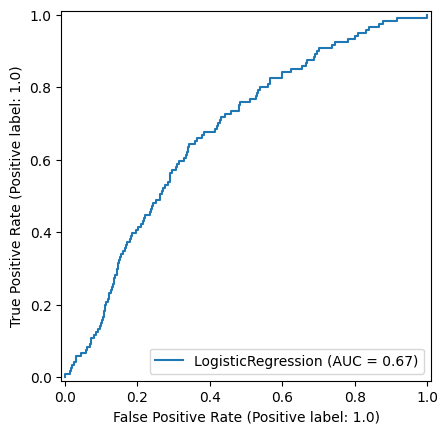

In [13]:
from sklearn.metrics import RocCurveDisplay
clf_lor = LogisticRegression(solver='liblinear', random_state= 42)
clf_lor.fit(X_train, y_train)

roc_curve_display = RocCurveDisplay.from_estimator(estimator=clf_lor, 
                                                   X=X_test, 
                                                   y=y_test)

roc_curve_display

The AUC for Logistic Regression is 0.67 which signifies mediocre performance and we would want to improve that.


# Now let's try 3 different models:

ok let's find the best parameters to predict and test it in comparison to our y_test data.

Note: You will see an extra model DecisionTreeClassifier, but this model will be used inside the AdaBoost Classifier, and i will be finding the optimal parameters for it to increase its prediction.

    1) KNeighbors Classifier parameters:

In [16]:
KNC = KNeighborsClassifier()
KNC.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

    2a) AdaBoost Classifier parameters:

In [17]:
ADB = AdaBoostClassifier(algorithm='SAMME')
ADB.get_params()

{'algorithm': 'SAMME',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

    2b) DecisionTree Classifier parameters:

In [18]:
DTC = DecisionTreeClassifier()
DTC.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

    3) GradientBoosting Classifier parameters:

In [19]:
GBC =  GradientBoostingClassifier()
GBC.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

# What parameters are best to increase the accuracy of the model for better predictions and how can we find them? :-

The answer: Grid-search

We will use Grid-search to find the optimal hyperparameters of a model that results in the most ‘accurate’ predictions. 

After i have found the optimal hyperparameters,  I chose these paramaters to tune them into a ML model.

In [20]:
learning_rate = [.001,.1,.3]
max_depth = [5,4]

# n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski'
params_ADB = {'learning_rate': [0.1, 0.3],
              'n_estimators':[50, 100],
              'random_state': [42]}
params_KNC = {
    'n_neighbors': (1,10, 1),
    'leaf_size': (20,40,1), 'p': (1,2),
    'weights': ('uniform', 'distance')}

params_GBC = {'learning_rate': learning_rate,
              'max_depth': max_depth
             }

params_DTC = {'max_depth': [1, 3],
              'max_features': [15, None]}

In [21]:
scoring = 'roc_auc'
cv = 2
verbose = 3

cv_DTC = GridSearchCV(estimator=DTC,
        param_grid=params_DTC,
        scoring=scoring,
        cv=cv, verbose=verbose)

cv_ADB = GridSearchCV(estimator=ADB,
        param_grid=params_ADB,
        scoring=scoring,
        cv=cv, verbose=verbose)

cv_KNC = GridSearchCV(estimator=KNC,
        param_grid=params_KNC,
        scoring=scoring,
        cv=cv, verbose=verbose)

cv_GBC = GridSearchCV(estimator=GBC,
        param_grid=params_GBC,
        scoring=scoring,
        cv=cv, verbose=verbose)

In [22]:
n = 20000
grids = [cv_DTC, cv_ADB, cv_KNC, cv_GBC]

for grid in grids:
    grid.fit(X_train ,y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ......max_depth=1, max_features=15;, score=0.622 total time=   0.2s
[CV 2/2] END ......max_depth=1, max_features=15;, score=0.512 total time=   0.1s
[CV 1/2] END ....max_depth=1, max_features=None;, score=0.638 total time=   0.2s
[CV 2/2] END ....max_depth=1, max_features=None;, score=0.628 total time=   0.2s
[CV 1/2] END ......max_depth=3, max_features=15;, score=0.523 total time=   0.1s
[CV 2/2] END ......max_depth=3, max_features=15;, score=0.522 total time=   0.1s
[CV 1/2] END ....max_depth=3, max_features=None;, score=0.762 total time=   0.3s
[CV 2/2] END ....max_depth=3, max_features=None;, score=0.752 total time=   0.3s
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END learning_rate=0.1, n_estimators=50, random_state=42;, score=0.728 total time=   3.9s
[CV 2/2] END learning_rate=0.1, n_estimators=50, random_state=42;, score=0.718 total time=   3.9s
[CV 1/2] END learning_rate=0.1, n_esti

[CV 1/2] END leaf_size=1, n_neighbors=1, p=2, weights=distance;, score=0.499 total time=   4.5s
[CV 2/2] END leaf_size=1, n_neighbors=1, p=2, weights=distance;, score=0.499 total time=   4.5s
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ..learning_rate=0.001, max_depth=5;, score=0.769 total time=  32.9s
[CV 2/2] END ..learning_rate=0.001, max_depth=5;, score=0.752 total time=  33.3s
[CV 1/2] END ..learning_rate=0.001, max_depth=4;, score=0.763 total time=  26.3s
[CV 2/2] END ..learning_rate=0.001, max_depth=4;, score=0.762 total time=  27.1s
[CV 1/2] END ....learning_rate=0.1, max_depth=5;, score=0.718 total time=  33.3s
[CV 2/2] END ....learning_rate=0.1, max_depth=5;, score=0.741 total time=  32.7s
[CV 1/2] END ....learning_rate=0.1, max_depth=4;, score=0.714 total time=  25.9s
[CV 2/2] END ....learning_rate=0.1, max_depth=4;, score=0.737 total time=  26.0s
[CV 1/2] END ....learning_rate=0.3, max_depth=5;, score=0.690 total time=  33.5s
[CV 2/2] END ....le

In [23]:
#now to find the best one of the them, we will loop through it:
grids_dict = {0: 'DescisionTree', 1:'AdaBoost', 2:'K-Nearest Neighbors', 3:'GradientBoosting'}
for i, model in enumerate(grids):
    print('{} AUC score: {}'.format(grids_dict[i], model.score(X_train ,y_train)))
    print('{} Best parameters: {}'.format(grids_dict[i], model.best_params_))
    

DescisionTree AUC score: 0.7714811297596902
DescisionTree Best parameters: {'max_depth': 3, 'max_features': None}
AdaBoost AUC score: 0.7647604691010177
AdaBoost Best parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'random_state': 42}
K-Nearest Neighbors AUC score: 1.0
K-Nearest Neighbors Best parameters: {'leaf_size': 20, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
GradientBoosting AUC score: 0.8036082643379849
GradientBoosting Best parameters: {'learning_rate': 0.001, 'max_depth': 4}


In [24]:
cv_KNC.best_params_

{'leaf_size': 20, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}

In [25]:
cv_GBC.best_params_

{'learning_rate': 0.001, 'max_depth': 4}

In [26]:
cv_DTC.best_params_

{'max_depth': 3, 'max_features': None}

In [27]:
cv_ADB.best_params_

{'learning_rate': 0.3, 'n_estimators': 50, 'random_state': 42}

# Tuning best parameters into the models: 
    1) KNeighbors Classifier
    2) GradientBoosting Classifier
    3) AdaBoost Classifier

# 1) KNeighbors Classifier

In [16]:
clf_KNC = KNeighborsClassifier(leaf_size= 20, n_neighbors = 1, p=1, weights= 'uniform')
clf_KNC.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=20, n_neighbors=1, p=1)

In [17]:
pred_KNC = clf_KNC.predict(X_test)

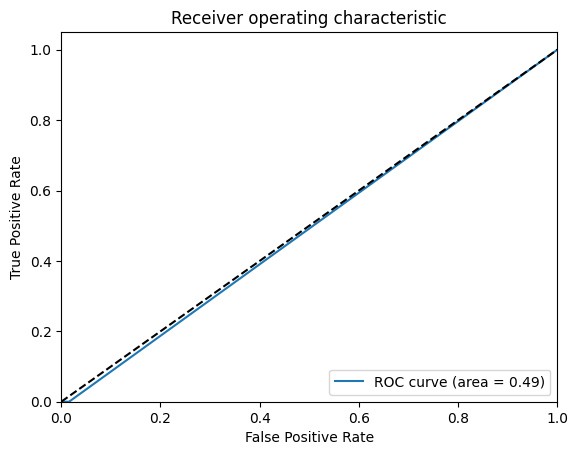

In [18]:
y_pred = clf_KNC.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_Rate, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_Rate) # compute area under the curve
plt.figure()
plt.plot(false_positive_rate, true_positive_Rate, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

Analysis of the performance KNeighbors Classifier, we can see the the ROC curve is 0.5, it's bad, but the KNeighbors Classifier is known to get significantly impacted by imbalanced class distributions of data. However, there could be other reasons for it as you will see when using this model to predict on the test set, the number of customers will be very close to the actual numberin the training set. 

Generally, If the data is imbalanced the argument about what the reason is changes, and the accuracy of the model could be useless so consider trying out other evaluation metrics such as precision, recall, and the confusion matrix instead. We have preformed confusion matrix on all the 3 models in case you didn't know how to analyse it, it's an array of 2x2, the first element(0,0) = True Positive, (0,1) = False Negative, (1,0) = False Positive, (1,1) = True Negative. The indices that i just described is based on the position of numbers in an array. The internet will describe it differently, so be aware that i analysed it based on the position of numbers in an array. 

In [19]:
#y_test: # True labels, pred_: predicted_labels
accuracy_score(y_test, pred_KNC)

0.970441056674037

In [20]:
roc_auc_score(y_test, pred_KNC)

0.49215061378659114

In [21]:
confusion_matrix(y_test, pred_KNC)

array([[8339,  133],
       [ 121,    0]])

# 2) GradientBoosting Classifier

In [22]:
clf_GBC = GradientBoostingClassifier(learning_rate= 0.001, max_depth= 4)

In [23]:
clf_GBC.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.001, max_depth=4)

In [25]:
pred_GBC = clf_GBC.predict(X_test)

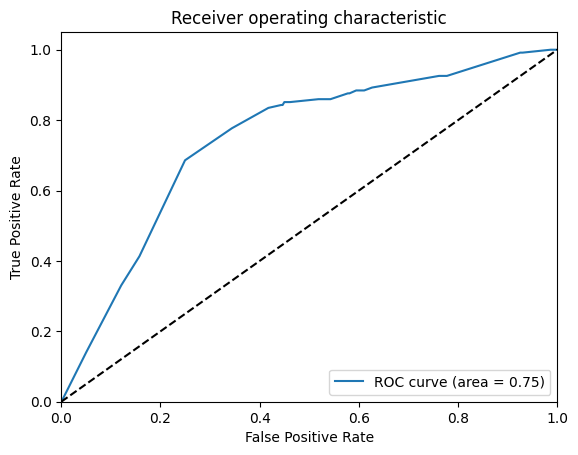

In [26]:
y_pred = clf_GBC.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_Rate, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_Rate) # compute area under the curve
plt.figure()
plt.plot(false_positive_rate, true_positive_Rate, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [27]:
accuracy_score(y_test, pred_GBC)

0.98591877109275

In [28]:
roc_auc_score(y_test, pred_GBC)

0.5

In [29]:
confusion_matrix(y_test,pred_GBC)

array([[8472,    0],
       [ 121,    0]])

# 3) AdaBoost Classifier

In [30]:
clf_ADB = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,max_features=None), algorithm= 'SAMME', learning_rate=0.3, n_estimators=50)

In [31]:
clf_ADB.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.3)

In [32]:
pred_ADB = clf_ADB.predict(X_test)

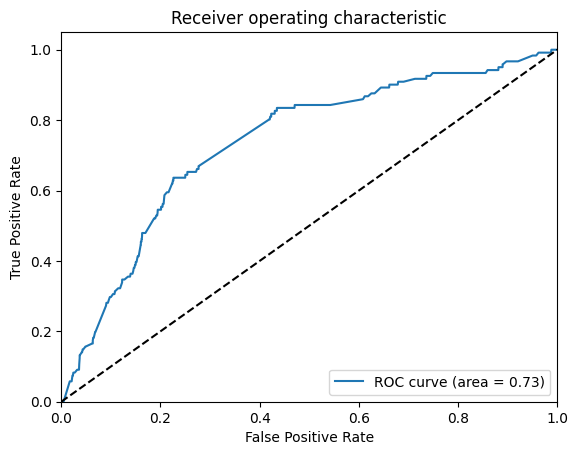

In [33]:
y_pred = clf_ADB.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_Rate, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_Rate) # compute area under the curve
plt.figure()
plt.plot(false_positive_rate, true_positive_Rate, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [34]:
#check accuracy score
accuracy_score(y_test,pred_ADB)

0.98591877109275

In [35]:
roc_auc_score(y_test, pred_ADB)

0.5

In [36]:
confusion_matrix(y_test, pred_ADB)

array([[8472,    0],
       [ 121,    0]])

# Testing the models: 

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test these models.

In [37]:
test_set = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

test_set.head(5)

/tmp/ipykernel_619/1364449250.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_set = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [38]:
test_set.shape

(42833, 366)

In [39]:
test_set = clean_data(test_set)

A) The First Step: Dropping the unnecessary columns. 

The columns that were successfully dropped are: 
 1) Columns that have more than 20% of missing values. 
 2) Columns that have no description in the files. 
 3) Columns that are noisy because it contains many different items. 
 4) The ID Column.
Creating a copy of the dataframe after dropping columns. 

B) The Second Step: Replace O with 0 and W with 1 in OST_WEST_KZ attribute. 

C) The Third Step: Rename the WOHNLAGE column to TYPE_RESIDENTIAL_AREA. 

D) The Fourth Step: apply feature engineering on TYPE_RESIDENTIAL_AREA values. It is better to reduce the noise. 

E) The Fifth Step: Dropping the original column: WOHNLAGE. 

Feature extracting CAMEO_DEUG_2015. 

F) The Sixth Step: Checking the values of the object type column: CAMEO_DEUG_2015 and transforming to a numeric type. 

G) The Seventh Step: removing columns with start with KBA05. 
 
H) The Eighth Step: Imputing Nan values using the most frequent number.


In [40]:
# Copy the 'LNR' column
X_col = X.drop('LNR',axis=1)
col = X_col.columns.tolist()

In [41]:
X_col.head(2)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,ALTERSKATEGORIE_GROB,TYPE_RESIDENTIAL_AREA
0,1.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,...,4.0,1.0,2.0,5.0,2.0,6.0,9.0,3.0,4.0,2.0
1,4.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,...,0.0,1.0,3.0,1.0,2.0,4.0,9.0,1.0,3.0,1.0


# Kneighbors Classifier

In [42]:
clf_KNC.fit(X_col, y)

KNeighborsClassifier(leaf_size=20, n_neighbors=1, p=1)

In [43]:
tests_pred_KNC = clf_KNC.predict(test_set[col])

In [44]:
tsts_pred_KNC=clf_KNC.predict_proba(test_set[col])

In [45]:
tsts_pred_KNC[:, 1].sum()


511.0

It is important to distinguish what tsts_pred_KNC[:, 1] means: For binary classification, the output array will have two columns:
Column 0: Probability of the sample belonging to class 0 (negative class).
Column 1: Probability of the sample belonging to class 1 (positive class).

A simple example, lets say index 0:20% and index 1: 80%, the first sample has a 20% chance of being in class 0 and an 80% chance of being in class 1.

This part selects all rows (:) but only the second column (1), which corresponds to the probabilities of the positive class (class 1).
And even though this Classifier gets affected by imbalanced data and its roc curve is poor, the accuracy is quite good, as this results consists of an array of 0 and ones as an accuracy result, so i summed the positive classes up and i recived 511 of customers. From the prediction results we conclude that among the 42.833 persons included in the marketing campaign, 511 will respond positively and become new clients. This corresponds to a 1.193% response rate. The predicted response rate in the test set is close to the response rate of 1,25% (532/42430) in the given training set.


In [46]:
test_ids = test_set["LNR"].astype('Int32')
results_df = {"LNR": test_ids,
                 "RESPONSE": tsts_pred_KNC[:,1]}
results = pd.DataFrame(results_df)
results.head(10)

,LNR,RESPONSE
0,1754,0.0
1,1770,0.0
2,1465,0.0
3,1470,0.0
4,1478,0.0
5,1782,0.0
6,1485,0.0
7,1519,0.0
8,1835,0.0
9,1522,0.0


# GradientBoosting Classifier 

In [47]:
clf_GBC.fit(X_col, y)

GradientBoostingClassifier(learning_rate=0.001, max_depth=4)

In [49]:
tests_pred_GBC = clf_GBC.predict(test_set[col])

In [53]:
tsts_pred_GBC = clf_GBC.predict_proba(test_set[col])


In [54]:
tsts_pred_GBC[:, 1]

array([0.01433385, 0.01392055, 0.01146293, ..., 0.01392055, 0.01433385,
       0.01392055])

In [51]:
test_ids = test_set["LNR"].astype('Int32')
results_df = {"LNR": test_ids,
                 "RESPONSE": tsts_pred_GBC[:,1]}
results = pd.DataFrame(results_df)

In [52]:
results.head(10)

,LNR,RESPONSE
0,1754,0.014334
1,1770,0.013921
2,1465,0.011463
3,1470,0.011463
4,1478,0.011463
5,1782,0.011463
6,1485,0.011903
7,1519,0.013921
8,1835,0.013921
9,1522,0.011463


# AdaBoost Classifier

In [55]:
clf_ADB.fit(X_col, y)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.3)

In [56]:
tests_pred_ADB = clf_ADB.predict(test_set[col])

In [57]:
tsts_pred_ADB = clf_ADB.predict_proba(test_set[col])

In [58]:
tsts_pred_ADB[:, 1]

array([0.27892181, 0.25172074, 0.14817663, ..., 0.20591471, 0.2312146 ,
       0.1997989 ])

In [59]:
test_ids = test_set["LNR"].astype('Int32')
results_df = {"LNR": test_ids,
                 "RESPONSE": tsts_pred_ADB[:,1]}
results = pd.DataFrame(results_df)

In [60]:
results.head(10)

,LNR,RESPONSE
0,1754,0.278922
1,1770,0.251721
2,1465,0.148177
3,1470,0.143886
4,1478,0.131632
5,1782,0.143348
6,1485,0.140107
7,1519,0.222278
8,1835,0.217436
9,1522,0.146636


# Conclusion:-

All the 3 models follow the same fundamental idea, these algorithms proved to boost their performance using weak learners.  After evaluating the Models based on roc_curve metrics we saw that each one has its weaknesses: 

    -KNeighbors Classifier scored very poor roc_curve/auc: .49 because the data is imbalanced nonetheless we did see in KNeighbors Classifier that the sum of the actual customers number is very close to the number we have seen and was provided to us in the train set in the RESPONSE column of 532. For this imbalanced data Ada Boost is better and ROC curve agrees which is rather significant that it does.

Which is why:

    -Ada Boost is better for overcoming imbalanced classes of binary classes and uses up-weights for misclassifying a data point. For this imbalanced data Ada Boost is better and ROC curve agrees which is rather significant that it does.

For this classification problem, Adaboost is the better in predicting probalility of whether or not person become a customer of the campaign.

# Analysis of AdaBoost Classifier: 

    1) Extract Feature Importance:

In [104]:
feat_importance=clf_ADB.feature_importances_


    2) Sort and Identify Top Features:

In [117]:
num_feat =10
# argsort: returns the indices that would sort the feat_importance array in ascending order.
indices = np.argsort(feat_importance)[::-1]
# columns: The names of the top 5 most important features.
top_columns = X_train.columns.values[indices[:num_feat]]

# values: The corresponding importance scores for those features.
top_values = feat_importance[indices][:num_feat]

    3) Plot

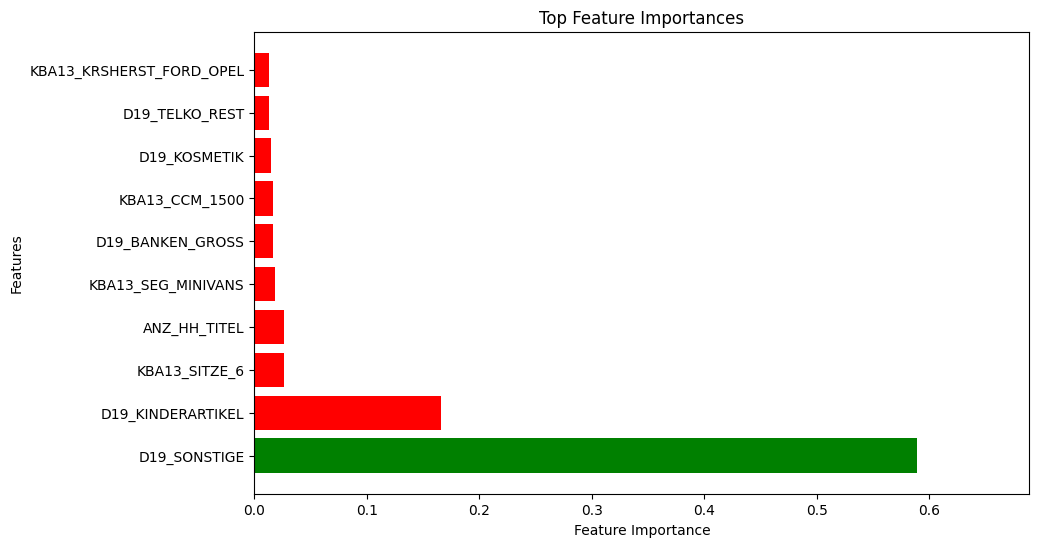

In [120]:
# Plotting
colors = ['green' if val >= 0.4 else 'orange' if val >= 0.2 else 'red' for val in top_values]

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))
plt.barh(top_columns, top_values, color=colors)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top Feature Importances')
plt.xlim(0, max(top_values) + 0.1)  # Adding a little space to the right
plt.show()

# Reflection:-
    
For this particluar project, the most excting part:
 1) Understanding the impediment of ML models and how roc curve can play a huge parts in understanding ML models.
 2) Comparing both the general population and customers dataset
 3) Comprehending the features and characteristics(features) of people that become customers of this campaign.
    
The Most difficult part was how improve the accuaracy(ROC curve) of the models and that had to be done with lots of preprocseeing and feature engineering steps and dealing with lots of NaN data points which was very challenging especially on how to deal with them in a way that improves the model and not the opposite.

# Improvments:-

Before all the cleaning and prepocessing that i applied on the datasets, i was skeptical on how to deal with the nan values, and it caused me problems as i wanted to improve the models, so first i deleted them however that didn't go well so i had rethink my method and instead i used Simple Imputation(A provided Class) with most frequent numbers instead of the mean, i did improve it.